## Literature

https://quantpy.com.au/stochastic-calculus/brownian-motion-for-financial-mathematics/


https://www.youtube.com/watch?v=sIKD1tQryHg

https://www.quantstart.com/articles/geometric-brownian-motion-simulation-with-python/

https://towardsdatascience.com/stochastic-processes-simulation-brownian-motion-the-basics-c1d71585d9f9


https://github.com/GariZabaleta/jpx-tokyo-stock-exchange-prediction/blob/master/jpx-prediction.ipynb


https://towardsdatascience.com/5-amazing-pandas-features-you-probably-dont-know-about-5533498aac88


**Calculating log values**

https://stackoverflow.com/questions/31742545/python-calculating-log-returns-of-a-time-series



### Import libraries

---



In [1]:
import math
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error

### Generating Geometric Brownian motion

---

In [3]:
# gbm.py

import os
import random
import string
import numpy as np
import pandas as pd


class GeometricBrownianMotionAssetSimulator:
    """
    This callable class will generate a daily
    open-high-low-close-volume (OHLCV) based DataFrame to simulate
    asset pricing paths with Geometric Brownian Motion for pricing
    and a Pareto distribution for volume.

    It will output the results to a CSV with a randomly generated
    ticker smbol.

    For now the tool is hardcoded to generate business day daily
    data between two dates, inclusive.

    Note that the pricing and volume data is completely uncorrelated,
    which is not likely to be the case in real asset paths.

    Parameters
    ----------
    start_date : `str`
        The starting date in YYYY-MM-DD format.
    end_date : `str`
        The ending date in YYYY-MM-DD format.
    init_price : `float`
        The initial price of the asset.
    mu : `float`
        The mean 'drift' of the asset.
    sigma : `float`
        The 'volatility' of the asset.
    """

    def __init__(
        self,
        start_date,
        end_date,
        init_price,
        mu,
        sigma,
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.init_price = init_price
        self.mu = mu
        self.sigma = sigma

    def _generate_random_symbol(self):
        """
        Generates a random ticker symbol string composed of
        uppercase ASCII characters to use in the CSV output filename.

        Returns
        -------
        `str`
            The random ticker string composed of uppercase letters.
        """
        return ''.join(
            random.choices(
                string.ascii_uppercase,
                k=4
            )
        )

    def _create_empty_frame(self,symbol):
        """
        Creates the empty Pandas DataFrame with a date column using
        business days between two dates. Each of the price/volume
        columns are set to zero.

        Returns
        -------
        `pd.DataFrame`
            The empty OHLCV DataFrame for subsequent population.
        """
        date_range = pd.date_range(
            self.start_date,
            self.end_date,
            freq='B'
        )

        zeros = pd.Series(np.zeros(len(date_range)))

        return pd.DataFrame(
            {
                'date': date_range,
                symbol: zeros
            }
        )[['date', symbol]]

    def _create_geometric_brownian_motion(self, data):
        """
        Calculates an asset price path using the analytical solution
        to the Geometric Brownian Motion stochastic differential
        equation (SDE).

        This divides the usual timestep by four so that the pricing
        series is four times as long, to account for the need to have
        an open, high, low and close price for each day. These prices
        are subsequently correctly bounded in a further method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame needed to calculate length of the time series.

        Returns
        -------
        `np.ndarray`
            The asset price path (four times as long to include OHLC).
        """
        n = len(data)
        T = n / 252.0  # Business days in a year
        dt = T / (4.0 * n)  # 4.0 is needed as four prices per day are required
        
        # Vectorised implementation of asset path generation
        # including four prices per day, used to create OHLC
        asset_path = np.exp(
            (self.mu - self.sigma**2 / 2) * dt +
            self.sigma * np.random.normal(0, np.sqrt(dt), size=(4 * n))
        )
        
        return self.init_price * asset_path.cumprod()

    def _append_path_to_data(self, data, path,symbol):
        """
        Correctly accounts for the max/min calculations required
        to generate a correct high and low price for a particular
        day's pricing.

        The open price takes every fourth value, while the close
        price takes every fourth value offset by 3 (last value in
        every block of four).

        The high and low prices are calculated by taking the max
        (resp. min) of all four prices within a day and then
        adjusting these values as necessary.

        This is all carried out in place so the frame is not returned
        via the method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The price/volume DataFrame to modify in place.
        path : `np.ndarray`
            The original NumPy array of the asset price path.
        """
        data[symbol] = path[3::4]


    def __call__(self):
        """
        The entrypoint for generating the asset OHLCV frame. Firstly this
        generates a symbol and an empty frame. It then populates this
        frame with some simulated GBM data. The asset volume is then appended
        to this data and finally it is saved to disk as a CSV.
        """
        symbol = self._generate_random_symbol()
        data = self._create_empty_frame()
        path = self._create_geometric_brownian_motion(data)
        self._append_path_to_data(data, path)


def gen(random_seed, start_date, end_date, init_price, mu, sigma):
    random_seed = int(random_seed)
    init_price = float(init_price)
    mu = float(mu)
    sigma = float(sigma)

    # Need to seed both Python and NumPy separately
    random.seed(random_seed)
    np.random.seed(seed=random_seed)

    gbmas = GeometricBrownianMotionAssetSimulator(
        start_date,
        end_date,
        init_price,
        mu,
        sigma,
    )
    return gbmas
     

In [17]:
start_data = "2020-01-01"
end_data = "2022-12-31"

In [18]:
df = []
for i in range(0,10):
  stock = gen(i, start_data, end_data,100,0.1,0.2)

  symbol = stock._generate_random_symbol()        
  data = stock._create_empty_frame(symbol)
  path = stock._create_geometric_brownian_motion(data)
  stock._append_path_to_data(data, path,symbol)

  if i == 0:
    df = data.copy()
  else:
    df = pd.concat([df,data[symbol]], axis = 1)

df = df.set_index("date")

In [19]:
display(df)

,VTKG,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,,
2020-01-01,103.482514,99.661567,99.423036,100.320863,100.188276,101.484616,99.865500,101.086409,98.685564,99.142575
2020-01-02,104.622631,99.409426,97.360879,99.507999,98.932934,101.639198,98.671030,99.511884,101.265104,97.398578
2020-01-03,105.919790,99.110562,97.931147,98.945510,98.787116,100.689973,101.503570,100.059747,102.907880,98.346670
2020-01-06,107.067359,98.722860,97.265252,100.381085,98.788299,99.385565,102.268960,99.180151,101.040579,100.417669
2020-01-07,107.607129,98.490010,97.552069,99.024389,99.889633,100.767928,103.185455,98.853801,101.298598,101.596601
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,71.067062,213.758504,100.314315,81.111485,161.343203,117.728133,210.063024,84.539960,171.407073,113.263651
2022-12-27,73.317685,210.799008,101.338784,80.173586,160.186298,114.655123,210.003703,84.487563,169.743235,114.248611
2022-12-28,74.168036,214.178859,102.304109,79.764877,161.386152,115.848259,208.756697,82.575989,170.572060,113.078237


In [20]:
n = random.randint(0,10)

In [21]:
X = df.copy()
X.drop(X.columns[n], axis=1, inplace = True)
y = df.iloc[:,n]

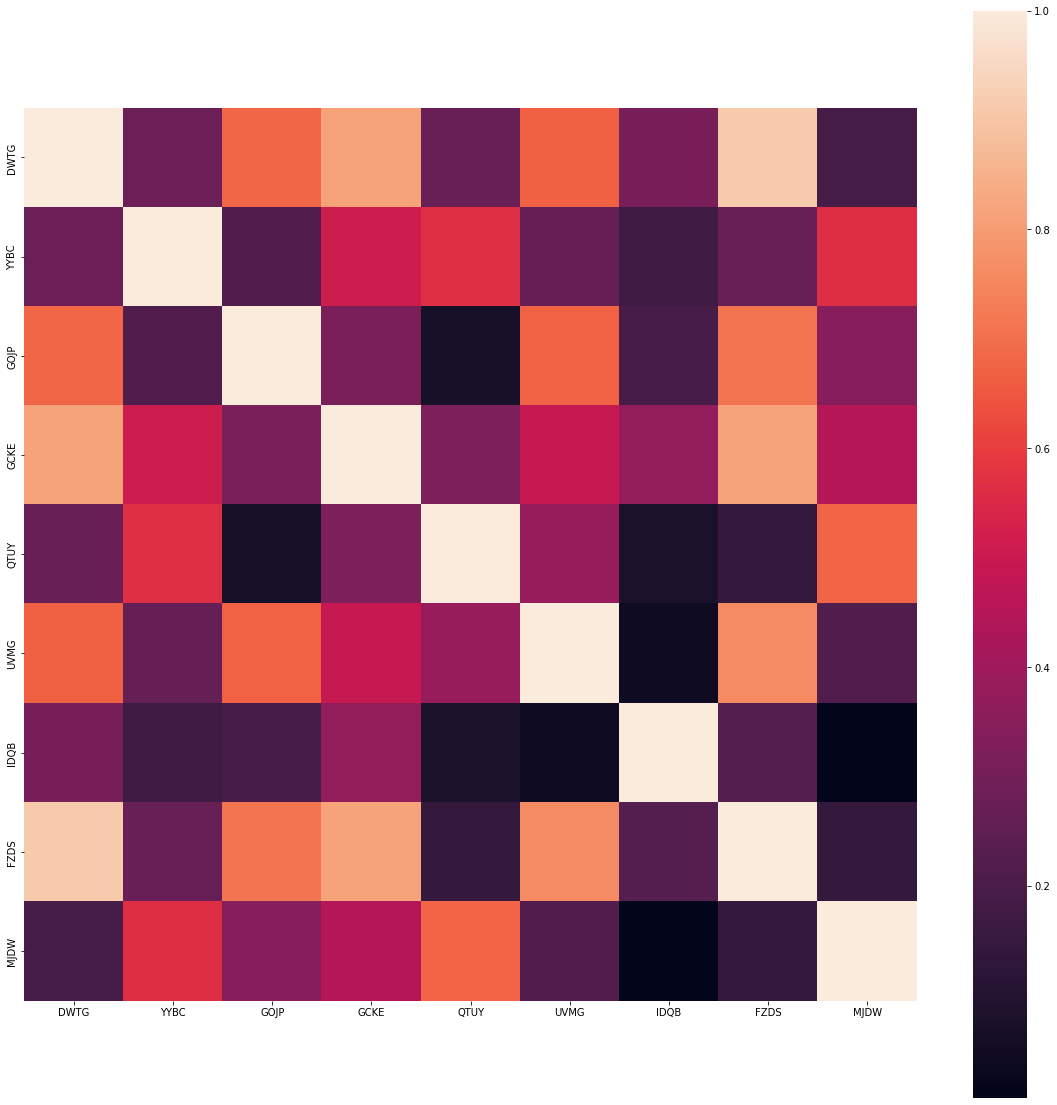

In [22]:
corr_mat = np.abs(X.corr())
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_mat,square = True, ax = ax)

In [23]:
period = [3,5,10,21]
col = X.columns
for j in col:
  for i in period:
    X[f"pct_{j}_{i}"] = X[j].pct_change(i)
    X[f"pct_{j}_{i}"] = X[f"pct_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

    X[f"Volatility_{j}_{i}"] = np.log(df[j]).diff().rolling(i).std()
    X[f"Volatility_{j}_{i}"] = X[f"Volatility_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

In [24]:
X

,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW,pct_DWTG_3,...,pct_FZDS_21,Volatility_FZDS_21,pct_MJDW_3,Volatility_MJDW_3,pct_MJDW_5,Volatility_MJDW_5,pct_MJDW_10,Volatility_MJDW_10,pct_MJDW_21,Volatility_MJDW_21
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,99.661567,99.423036,100.320863,100.188276,101.484616,99.865500,101.086409,98.685564,99.142575,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-02,99.409426,97.360879,99.507999,98.932934,101.639198,98.671030,99.511884,101.265104,97.398578,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-03,99.110562,97.931147,98.945510,98.787116,100.689973,101.503570,100.059747,102.907880,98.346670,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-06,98.722860,97.265252,100.381085,98.788299,99.385565,102.268960,99.180151,101.040579,100.417669,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-07,98.490010,97.552069,99.024389,99.889633,100.767928,103.185455,98.853801,101.298598,101.596601,-0.009249,...,0.050806,0.014908,0.043101,0.005949,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,213.758504,100.314315,81.111485,161.343203,117.728133,210.063024,84.539960,171.407073,113.263651,0.046344,...,-0.131626,0.010860,-0.007677,0.008637,-0.024861,0.008292,-0.025173,0.009006,-0.070332,0.010099
2022-12-27,210.799008,101.338784,80.173586,160.186298,114.655123,210.003703,84.487563,169.743235,114.248611,0.030234,...,-0.135616,0.010873,-0.005945,0.009600,-0.014015,0.010382,-0.011234,0.009583,-0.045913,0.009912
2022-12-28,214.178859,102.304109,79.764877,161.386152,115.848259,208.756697,82.575989,170.572060,113.078237,0.025983,...,-0.124753,0.011171,-0.006257,0.009731,-0.009301,0.009118,-0.025574,0.009773,-0.062555,0.009808


In [25]:
X.drop(col, axis = 1, inplace = True)

In [26]:
X

,pct_DWTG_3,Volatility_DWTG_3,pct_DWTG_5,Volatility_DWTG_5,pct_DWTG_10,Volatility_DWTG_10,pct_DWTG_21,Volatility_DWTG_21,pct_YYBC_3,Volatility_YYBC_3,...,pct_FZDS_21,Volatility_FZDS_21,pct_MJDW_3,Volatility_MJDW_3,pct_MJDW_5,Volatility_MJDW_5,pct_MJDW_10,Volatility_MJDW_10,pct_MJDW_21,Volatility_MJDW_21
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-02,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-03,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-06,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2020-01-07,-0.009249,0.000783,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,0.001964,0.006635,...,0.050806,0.014908,0.043101,0.005949,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.046344,0.011855,0.042164,0.012785,0.044221,0.013665,0.159313,0.012413,0.051382,0.009194,...,-0.131626,0.010860,-0.007677,0.008637,-0.024861,0.008292,-0.025173,0.009006,-0.070332,0.010099
2022-12-27,0.030234,0.020753,0.026408,0.016215,0.035493,0.014566,0.126405,0.013080,0.054076,0.007964,...,-0.135616,0.010873,-0.005945,0.009600,-0.014015,0.010382,-0.011234,0.009583,-0.045913,0.009912
2022-12-28,0.025983,0.019864,0.048402,0.015538,0.037372,0.014724,0.156765,0.012699,0.046685,0.009339,...,-0.124753,0.011171,-0.006257,0.009731,-0.009301,0.009118,-0.025574,0.009773,-0.062555,0.009808


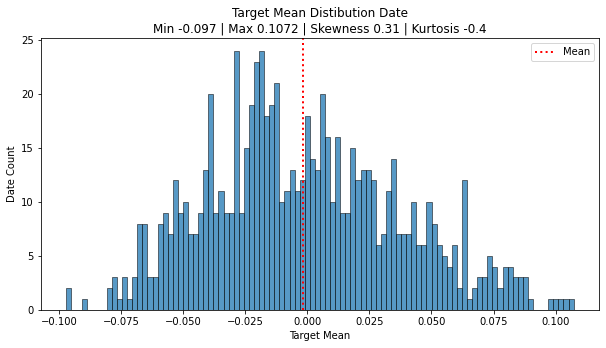

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=X["pct_IDQB_10"].values, bins=100,
             ax=ax)
ax.axvline(x=X["pct_IDQB_10"].mean(), color='red', linestyle='dotted', linewidth=2, 
           label='Mean')

ax.set_title("Target Mean Distibution Date\n"
             f"""Min {round(X["pct_IDQB_10"].min(), 4)} | """
             f"""Max {round(X["pct_IDQB_10"].max(), 4)} | """
             f"""Skewness {round(X["pct_IDQB_10"].skew(), 2)} | """
             f"""Kurtosis {round(X["pct_IDQB_10"].kurtosis(), 2)}""")

ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()


In [28]:
ts_fold = TimeSeriesSplit(n_splits=10,gap=10000)


In [ ]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]
    
    print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
    print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))

In [ ]:
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]
    
    print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
    print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))
    
    
    ##### TRAIN standarization pipeline. See comment above
    """
    pipeline_X_df = full_pipeline.fit_transform(X_train)
    pipeline_X_df = pd.DataFrame(pipeline_X_df, columns = num_attribs)
    
    pipeline_X_df.reset_index(drop = True, inplace=True)
    X_train.reset_index(drop = True, inplace=True)

    X_train.drop(num_attribs,axis=1,inplace=True)
    X_train = pd.concat([X_train,pipeline_X_df], axis=1)
    #"""
    X_train= X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    ##### VALIDATION. See comment above
    """
    pipeline_val_df = full_pipeline.transform(X_valid)
    pipeline_val_df = pd.DataFrame(pipeline_val_df, columns = num_attribs)
    pipeline_val_df.reset_index(drop = True, inplace=True)
    X_valid.reset_index(drop = True, inplace=True)
    X_valid.drop(num_attribs,axis=1,inplace=True)
    X_valid = pd.concat([X_valid,pipeline_val_df], axis=1)
    
   # """
    X_valid= X_valid.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    X_train.drop(['Date','SecuritiesCode'], axis=1, inplace=True)
    X_val=X_valid[X_valid.columns[~X_valid.columns.isin(['Date','SecuritiesCode'])]]
    val_dates=X_valid.Date.unique()[1:-1]
    print("\nTrain Shape: {} {}, Valid Shape: {} {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    #gbm = LGBMRegressor(**params)
    gbm = LGBMRegressor().fit(X_train, y_train, 
                                      eval_set=[(X_train, y_train), (X_val, y_val)],
                                      verbose=300, 
                                      eval_metric=['mae','mse'])
    y_pred = gbm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
    feat_importance.set_index(X_train.columns, inplace=True)
        
    rank=[]
    X_val_df=X_valid[X_valid.Date.isin(val_dates)]
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date == i].drop(['Date','SecuritiesCode'],axis=1)
        temp_df["pred"] = gbm.predict(temp_df)
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        rank.append(temp_df["Rank"].values)

    stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
    df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,
                  df_prices_feat[df_prices_feat.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    sharpe=calc_spread_return_sharpe(df)
    sharpe_ratio.append(sharpe)
    print("Valid Sharpe: {}, RMSE: {}, MAE: {}".format(sharpe,rmse,mae))
    
    del X_train, y_train,  X_val, y_val ##, pipeline_val_df, pipeline_X_df
    gc.collect()
    
print("\nAverage cross-validation Sharpe Ratio: {:.4f}, standard deviation = {:.2f}.".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))